# Using DMD For Background Extraction 

This notebook was highly motivated by the following [paper](https://arxiv.org/pdf/1512.04205v1%20). The dynamic mode decomposition (DMD) is fundamentally an application of the singular value decomposition (SVD). The method takes a data set $X$ whose columns are snap shots in time of the dynamical system at hand. For the purposes of this notebook, these snapshots would be each frame of an mp4 video. Meaning if $\textbf{x}_0$ is a column of $X$ it would be the first frame of the video. The DMD then seeks to relate the column $\textbf{x}_{i+1}$ to the column $\textbf{x}_i$ via some linear transformation matrix $A$, i.e we seek to find $A$ such that 

\begin{equation}\tag{1}
\textbf{x}_{i+1} = A\textbf{x}_i
\end{equation} 

The eignvalues of $A$ describe the dynamic modes of the system under study. Mathematically, the matrix $A$ is given by 

$$ A = X'\cdot X^\dagger$$ 

where $X^\dagger$ is the psuedoinverse of $X$. Here $X$ and $X'$ are defined as the following: 

$$X = [x_0, x_2, \dots x_{m-1}] \,\,\text{ and } \,\,X' = [x_1, x_2, \dots x_m]  $$ 

The modes from $A$ can be used to extract the background from a video frame. Let $\omega_p$ describe a DMD eigenmode frequency, such that $||\omega_p|| \approx 0$ and that $||\omega_j||\forall j \neq p$ is bounded from zero. Then the following is the DMD reconstruction of $X$:

\begin{equation}\tag{2}
X_{\text{DMD}} = b_p \phi_p \exp\left(\omega_p t\right) + \sum_{j\neq p} b_j \phi_j \exp\left(\omega_j t\right) 
\end{equation} 

where each $\phi_j$ is an eigenvector of $A$ and $\omega_p$ related to the eigenvalues of $A$. Each continuous eigenvalue $\omega_j$ is related to the discrete eigenvalue $\lambda_j$ via the relationship 

$$\omega_j = \frac{1}{\Delta t} \log(\lambda_j) $$ 

where $\Delta t$ is the time between frames in the video. The low frequency $\omega_p$ drives the background of the video frame, and the non-zero frequencies describe the foreground of the video. 

This notebook will use highway footage from [changedetection](http://www.changedetection.net/), the goal is to extract the low frequency background and high frequency foreground into two data streams. The mp4 footage of the highway is already extracted into frames. To save computation time in the main funciton, we will read the images in the first cell. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# -- Note: The way I'm reading the images from a folder of frames is probably not optimal. It might be easier 
# to do this with an mp4 file as input and just retrieve the frames as needed.

# -- Helper function for get_Xs()
def im_helper(filepath):
    
    im = Image.open(filepath)
    image_array = np.array(im) 
    
    # -- Convert image to grayscale
    image_array = np.mean(image_array, axis = -1)
    image_array = image_array.flatten()
    
    return image_array 


# -- The loop in this function is a little hard to read due to how the frames were titled from the source folder. 
def get_Xs():

# -- Array X should contain images in000001 to in001699
# -- Array X_prime should contain images in000002 to in0017000

    filepath = r"D:\AudioEng\highway\in{zeros}{num}.jpg"
    
    L = 320*240
    X = np.zeros((L, 1699))
    X_prime = np.zeros((L, 1699))
    
    # -- There is 1700 frames to take as input, we don't want the last one for X 
    for k in range(1, 1701):
        
        if  k < 10:
            
            # -- Edit file path
            filepath1 = filepath.format(zeros = "00000", num = k)

            X[:, k-1] = im_helper(filepath1)
            
        if 10 <= k < 100:
              
            # -- Edit file path
            filepath2 = filepath.format(zeros = "0000", num = k)
        
            X[:, k-1] = im_helper(filepath2)
            
        
        if 100<= k < 1000:
            
             # -- Edit file path
            filepath3 = filepath.format(zeros = "000", num = k)
            
            X[:, k-1] = im_helper(filepath3)
        
        if 1000 <= k <=1699:
            
            
            # -- Edit file path
            filepath4 = filepath.format(zeros = "00", num = k)
             
            X[:, k-1] = im_helper(filepath4)
    
    # -- Shift X to obtain all of X_prime with the expection of the last value
    X_prime = np.roll(X, -1)
    
    # -- Need to replace X_prime[:, 1699] which is currently X[:, 0]
    filepath5 = filepath.format(zeros = "00", num = 1700)
    
    X_prime[:, 1698] = im_helper(filepath5)
        
    return X, X_prime

X, X_prime = get_Xs()

In [2]:
# -- Obtain the Dynamic Mode Decomposition 
def DMD(X, X_prime, r):
    
    # -- Obtain SVD for matrix X. Note Python returns V as V.conj().T. So in formulas wherever you see V^T you use
    # V from python, and wherever you see V you use V.conj().T
    U, S, V = np.linalg.svd(X, full_matrices = False) 
    S = np.diag(S)
       
    
    # -- This isn't working for some reason :/
    #U = U[:, 0:r]
    #S = S[0:r, 0:r]
    #V = V[:, 0:r]
    
    # -- Obtain truncated A matrix 
    A_tilde = (U.conj().T)@X_prime@(V.conj().T)@np.linalg.inv(S)

    # -- Obtain eigenvalues and eigenvectors of A 
    w, v = np.linalg.eig(A_tilde)
    
    # -- Construct eigendecomposition of A (the non truncated A). The columns of Phi are the eigenvectors of A
    Phi = X_prime@(V.conj().T)@np.linalg.inv(S)@v
    
    return Phi, w, v

# -- This value should be determined by a threshold algorithm, however I'm leaving it as a small number for now until
# I get the proof of concept to compile 
r = 50


Phi, w, v = DMD(X, X_prime, r)


We have now obtained the DMD of the highway footage. Let's take a look at the continuous eigenvalues of the system where 

$$\omega_k = \alpha + j\beta =  \frac{1}{\Delta t} \log(\lambda_k) $$ 

and each $\omega_k$ defines a mode $\exp((\alpha + j\beta)t)$

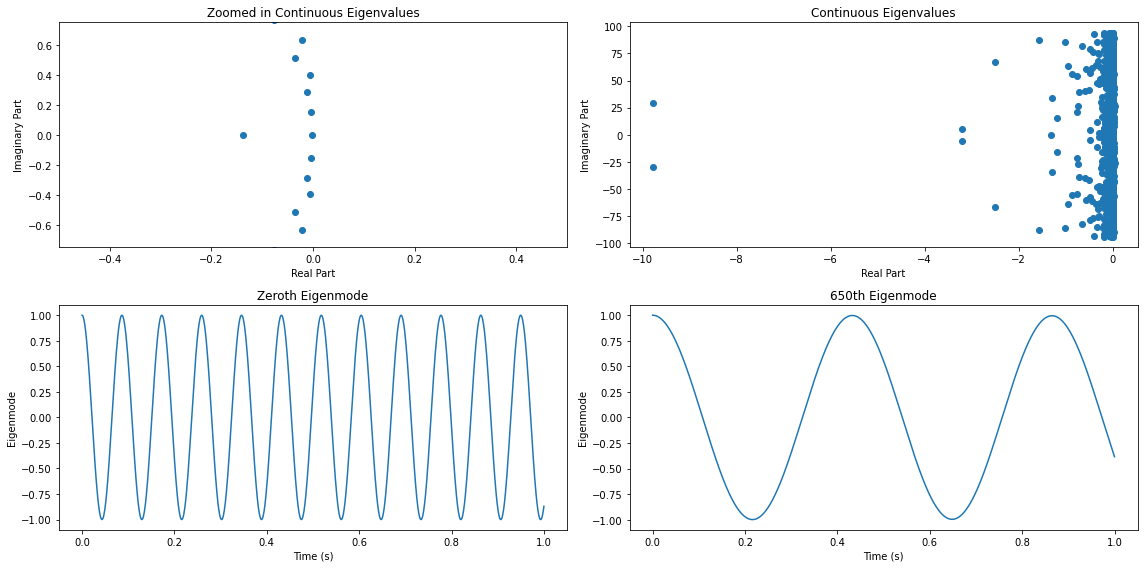

In [3]:
# -- Assume video is approximately 30fps 
dt = 1/30
t = np.linspace(0, 1, 1000)

omega = np.log(w)/dt

omega_r = omega.real
omega_i = omega.imag

# -- Plotting stuff 
fig, axs = plt.subplots(2,2, figsize=(16,8))
axs[0, 0].plot(omega_r, omega_i, 'o')
axs[0, 0].set_title('Zoomed in Continuous Eigenvalues')
axs[0, 0].set_xlabel('Real Part')
axs[0, 0].set_ylabel('Imaginary Part')
axs[0, 0].set_xlim(-0.5, 0.5)
axs[0, 0].set_ylim(-0.75, 0.75)

axs[0, 1].plot(omega_r, omega_i, 'o')
axs[0, 1].set_title('Continuous Eigenvalues')
axs[0, 1].set_xlabel('Real Part')
axs[0, 1].set_ylabel('Imaginary Part')

axs[1, 0].plot(t, np.exp(omega[0]*t).real)
axs[1, 0].set_title('Zeroth Eigenmode')
axs[1, 0].set_xlabel('Time (s)')
axs[1, 0].set_ylabel('Eigenmode')

axs[1, 1].plot(t, np.exp(omega[650]*t).real)
axs[1, 1].set_title('650th Eigenmode')
axs[1, 1].set_xlabel('Time (s)')
axs[1, 1].set_ylabel('Eigenmode')

fig.tight_layout() # Fixes figure layout 

From the zoomed in continuous eigenvalue plot, we can see that there is one continous eigenvalue very close to satisfying $||\omega|| \approx 0$. Also of note is the rapidly decaying high frequency components to the left of the zoomed out eigenvalue plot. This continuous eigenvalue corresponds to the background of the footage. Let's try to find the index of this eigenvalue and plot its eigenmode.

Text(0.5, 1.0, 'Comparison of 650th Eigenmode and Lowest Frequency Eigenmode')

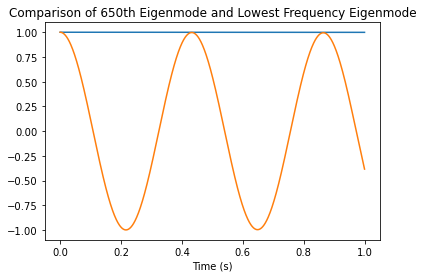

In [4]:
index = np.argwhere(np.abs(omega)<0.01)


plt.plot(t, np.exp(omega[index[0]]*t).real)
plt.plot(t, np.exp(omega[650]*t).real)
plt.xlabel('Time (s)')
plt.title('Comparison of 650th Eigenmode and Lowest Frequency Eigenmode')

We can see that the blue line, corresponding to the lowest continuous eigen mode barely oscillates over time and when compared to the orange line 650th eigenmode (which oscillates much slower than the zeroth as shown above) it's clear that this mode located at ```index[0]``` is the mode we want to filter out. Likely the easiest way to filter out this frequency is to represent it in a matrix $X_\text{LOW}$ and perform the following: 

\begin{equation}
X_\text{Foreground} = X - X_\text{LOW}
\end{equation} 

and then extract all of the columns in $X_{\text{Foreground}}$ and write the result to .jpg image file format.